<a href="https://colab.research.google.com/github/soumyb09/soumyb09/blob/master/Lasso_Ridge_PCR_PLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Model Selection and Regularization 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glmnet as gln

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')

In [0]:
df = pd.read_csv('Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, #NAME? to #NAME?
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


In [0]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
#NAME?,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
#NAME?,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
#NAME?,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
#NAME?,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
#NAME?,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [0]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, #NAME? to #NAME?
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
        League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
Player                                                                      
#NAME?         0         1           0           1            0            1
#NAME?         1         0           0           1            1            0
#NAME?         0         1           1           0            0            1
#NAME?         0         1           1           0            0            1
#NAME?         1         0           0           1            1            0


In [0]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, #NAME? to #NAME?
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7+ KB


In [0]:
X.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
#NAME?,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
#NAME?,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
#NAME?,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
#NAME?,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
#NAME?,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


In [0]:
X_train = pd.read_csv('Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv('Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Hitters_y_test.csv', index_col=0)

## Ridge Regression

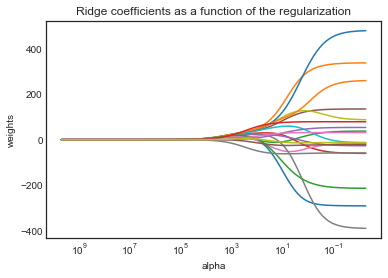

In [0]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

### Alpha = 4

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

In [0]:
ridge2 = Ridge(alpha=len(X_)*11498/2)
ridge2.fit(scaler.transform(X_train), y_train)
pred = ridge2.predict(scaler.transform(X_test))
mean_squared_error(y_test, pred)

193147.46143016344

In [0]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat          0.015146
Hits           0.016050
HmRun          0.013561
Runs           0.015681
RBI            0.016782
Walks          0.019662
Years          0.010390
CAtBat         0.016570
CHits          0.017627
CHmRun         0.015072
CRuns          0.018771
CRBI           0.016697
CWalks         0.016821
PutOuts        0.003228
Assists       -0.007600
Errors         0.013672
League_N       0.003519
Division_W     0.003339
NewLeague_N    0.003499
dtype: float64

### Alpha =  10^10

This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [0]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

193253.09741651407

### Compute the regularization path using RidgeCV

In [0]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([  5.00000e+09,   3.78232e+09, ...,   6.60971e-03,   5.00000e-03]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [0]:
ridgecv.alpha_

115.50648500415789

In [0]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))

97384.929591725886

In [0]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat           7.576771
Hits           22.596030
HmRun          18.971990
Runs           20.193945
RBI            21.063875
Walks          55.713281
Years          -4.687149
CAtBat         20.496892
CHits          29.230247
CHmRun         14.293124
CRuns          35.881788
CRBI           20.212172
CWalks         24.419768
PutOuts        16.128910
Assists       -44.102264
Errors         54.624503
League_N        5.771464
Division_W     -0.293713
NewLeague_N    11.137518
dtype: float64

In [0]:
grid = 10**np.linspace(10,-2,100)

ridge3 = gln.ElasticNet(alpha=0, lambda_path=grid)
ridge3.fit(X, y)

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True,
      lambda_path=array([  1.00000e+10,   7.56463e+09, ...,   1.32194e-02,   1.00000e-02]),
      max_iter=100000, min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100,
      n_splits=3, random_state=None, scoring=None, standardize=True,
      tol=1e-07, verbose=False)

### Lambda 11498

In [0]:
ridge3.lambda_path_[49]

11497.569953977356

In [0]:
print('Intercept: {:.3f}'.format(ridge3.intercept_path_[49]))

Intercept: 407.356


In [0]:
pd.Series(np.round(ridge3.coef_path_[:,49], decimals=3), index=X.columns)

AtBat          0.037
Hits           0.138
HmRun          0.525
Runs           0.231
RBI            0.240
Walks          0.290
Years          1.108
CAtBat         0.003
CHits          0.012
CHmRun         0.088
CRuns          0.023
CRBI           0.024
CWalks         0.025
PutOuts        0.016
Assists        0.003
Errors        -0.021
League_N       0.085
Division_W    -6.215
NewLeague_N    0.301
dtype: float64

In [0]:
np.sqrt(np.sum(ridge3.coef_path_[:,49]**2))

6.3606122865384505

### Lambda 705

In [0]:
ridge3.lambda_path_[59]

705.48023107186452

In [0]:
print('Intercept: {:.3f}'.format(ridge3.intercept_path_[59]))

Intercept: 54.325


In [0]:
pd.Series(np.round(ridge3.coef_path_[:,59], decimals=3), index=X.columns)

AtBat           0.112
Hits            0.656
HmRun           1.180
Runs            0.938
RBI             0.847
Walks           1.320
Years           2.596
CAtBat          0.011
CHits           0.047
CHmRun          0.338
CRuns           0.094
CRBI            0.098
CWalks          0.072
PutOuts         0.119
Assists         0.016
Errors         -0.704
League_N       13.684
Division_W    -54.659
NewLeague_N     8.612
dtype: float64

In [0]:
np.sqrt(np.sum(ridge3.coef_path_[:,59]**2))

57.11003436702412

### Fit Model Using Just the Training Set

In [0]:
ridge4 = gln.ElasticNet(alpha=0, lambda_path=grid, scoring='mean_squared_error', tol=1e-12)
ridge4.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True,
      lambda_path=array([  1.00000e+10,   7.56463e+09, ...,   1.32194e-02,   1.00000e-02]),
      max_iter=100000, min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100,
      n_splits=3, random_state=None, scoring='mean_squared_error',
      standardize=True, tol=1e-12, verbose=False)

In [0]:
# prediction using lambda = 4
pred = ridge4.predict(X_test, lamb=4)
mean_squared_error(y_test.values.ravel(), pred)

101036.83230892902

### Lambda Chosen by Cross Validation

In [0]:
ridge5 = gln.ElasticNet(alpha=0, scoring='mean_squared_error')
ridge5.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True, lambda_path=None,
      max_iter=100000, min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100,
      n_splits=3, random_state=None, scoring='mean_squared_error',
      standardize=True, tol=1e-07, verbose=False)

In [0]:
# Lambda with best CV performance
ridge5.lambda_max_

255.04348848905948

In [0]:
# Lambda larger than lambda_max_, but with a CV score that is within 1 standard deviation away from lambda_max_ 
ridge5.lambda_best_

array([ 1974.70910641])

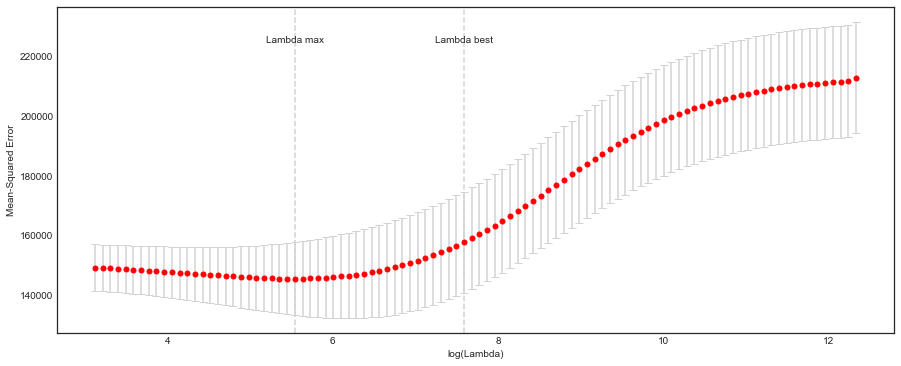

In [0]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(ridge5.lambda_path_), -ridge5.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=ridge5.cv_standard_error_, ecolor='lightgrey', capsize=4)

for ref, txt in zip([ridge5.lambda_best_, ridge5.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [0]:
# MSE for lambda with best CV performance
pred = ridge5.predict(X_test, lamb=ridge5.lambda_max_)
mean_squared_error(y_test, pred)

96006.845148505759

### Fit Model to the Full Data Set

In [0]:
ridge6= gln.ElasticNet(alpha=0, scoring='mean_squared_error', n_splits=10)
ridge6.fit(X, y)

ElasticNet(alpha=0, cut_point=1.0, fit_intercept=True, lambda_path=None,
      max_iter=100000, min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100,
      n_splits=10, random_state=None, scoring='mean_squared_error',
      standardize=True, tol=1e-07, verbose=False)

In [0]:
# These are not really close to the ones in the book.
pd.Series(ridge6.coef_path_[:,ridge6.lambda_max_inx_], index=X.columns)

AtBat           -0.681594
Hits             2.772311
HmRun           -1.365704
Runs             1.014812
RBI              0.713030
Walks            3.378558
Years           -9.066826
CAtBat          -0.001200
CHits            0.136102
CHmRun           0.697992
CRuns            0.295890
CRBI             0.257072
CWalks          -0.278966
PutOuts          0.263887
Assists          0.169878
Errors          -3.685656
League_N        53.209503
Division_W    -122.834334
NewLeague_N    -18.102528
dtype: float64

## Lasso Regression

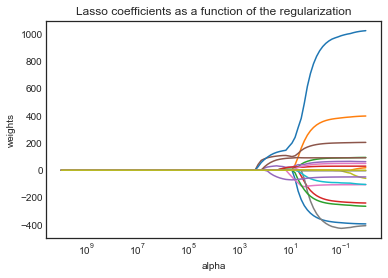

In [0]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [0]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.values.ravel())

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [0]:
lassocv.alpha_

30.013822564464284

In [0]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

102924.90954696963

In [0]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits             0.000000
HmRun            2.154219
Runs             0.000000
RBI             30.835560
Walks          104.071528
Years           -0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           0.000000
CRuns          132.858095
CRBI             0.000000
CWalks           0.000000
PutOuts          1.896185
Assists        -51.058752
Errors          76.779641
League_N         0.000000
Division_W       0.000000
NewLeague_N      0.000000
dtype: float64

In [0]:
lasso2 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error', n_splits=10)
lasso2.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=1, cut_point=1.0, fit_intercept=True,
      lambda_path=array([  1.00000e+10,   7.56463e+09, ...,   1.32194e-02,   1.00000e-02]),
      max_iter=100000, min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100,
      n_splits=10, random_state=None, scoring='mean_squared_error',
      standardize=True, tol=1e-07, verbose=False)

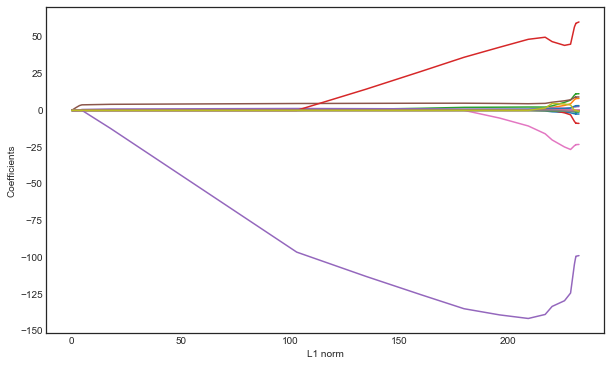

In [0]:
l1_norm = np.sum(np.abs(lasso2.coef_path_), axis=0)

plt.figure(figsize=(10,6))
plt.plot(l1_norm, lasso2.coef_path_.T)
plt.xlabel('L1 norm')
plt.ylabel('Coefficients');

In [0]:
lasso3 = gln.ElasticNet(alpha=1, scoring='mean_squared_error', n_splits=10)
lasso3.fit(X_train, y_train.values.ravel())

ElasticNet(alpha=1, cut_point=1.0, fit_intercept=True, lambda_path=None,
      max_iter=100000, min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100,
      n_splits=10, random_state=None, scoring='mean_squared_error',
      standardize=True, tol=1e-07, verbose=False)

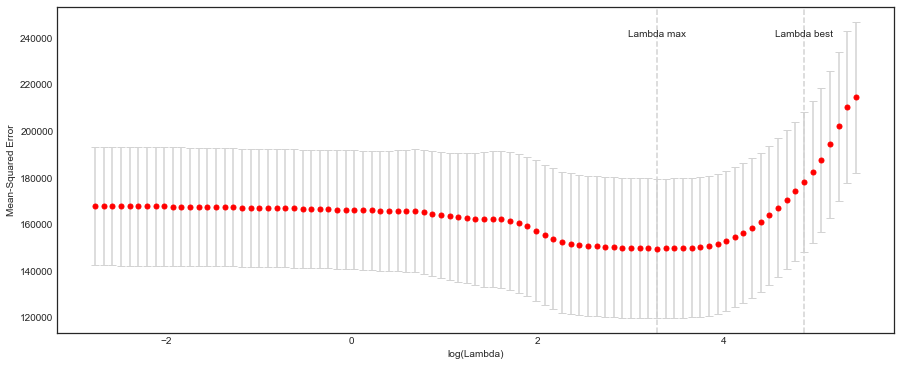

In [0]:
plt.figure(figsize=(15,6))
plt.errorbar(np.log(lasso3.lambda_path_), -lasso3.cv_mean_score_, color='r', linestyle='None', marker='o',
             markersize=5, yerr=lasso3.cv_standard_error_, ecolor='lightgrey', capsize=4)

for ref, txt in zip([lasso3.lambda_best_, lasso3.lambda_max_], ['Lambda best', 'Lambda max']):
    plt.axvline(x=np.log(ref), linestyle='dashed', color='lightgrey')
    plt.text(np.log(ref), .95*plt.gca().get_ylim()[1], txt, ha='center')

plt.xlabel('log(Lambda)')
plt.ylabel('Mean-Squared Error');

In [0]:
pred = lasso3.predict(X_test, lamb=lasso3.lambda_max_)
mean_squared_error(y_test, pred)

101294.32852317697

In [0]:
lasso4 = gln.ElasticNet(alpha=1, lambda_path=grid, scoring='mean_squared_error', n_splits=10)
lasso4.fit(X, y)

ElasticNet(alpha=1, cut_point=1.0, fit_intercept=True,
      lambda_path=array([  1.00000e+10,   7.56463e+09, ...,   1.32194e-02,   1.00000e-02]),
      max_iter=100000, min_lambda_ratio=0.0001, n_jobs=1, n_lambda=100,
      n_splits=10, random_state=None, scoring='mean_squared_error',
      standardize=True, tol=1e-07, verbose=False)

In [0]:
# These are not really close to the ones in the book.
pd.Series(lasso4.coef_path_[:,lasso4.lambda_max_inx_], index=X.columns)

AtBat           -1.560098
Hits             5.693168
HmRun            0.000000
Runs             0.000000
RBI              0.000000
Walks            4.750540
Years           -9.518024
CAtBat           0.000000
CHits            0.000000
CHmRun           0.519161
CRuns            0.660407
CRBI             0.391541
CWalks          -0.532687
PutOuts          0.272620
Assists          0.174816
Errors          -2.056721
League_N        32.109569
Division_W    -119.258342
NewLeague_N      0.000000
dtype: float64

In [0]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

print(pca.components_.shape)
pd.DataFrame(pca.components_.T).loc[:4,:5]

(19, 19)


,0,1,2,3,4,5
0,0.198290,-0.383784,0.088626,0.031967,0.028117,-0.070646
1,0.195861,-0.377271,0.074032,0.017982,-0.004652,-0.082240
2,0.204369,-0.237136,-0.216186,-0.235831,0.077660,-0.149646
3,0.198337,-0.377721,-0.017166,-0.049942,-0.038536,-0.136660
4,0.235174,-0.314531,-0.073085,-0.138985,0.024299,-0.111675


In [0]:
print(X_reduced.shape)
pd.DataFrame(X_reduced).loc[:4,:5]

(263, 19)


,0,1,2,3,4,5
0,-0.009649,1.870522,1.265145,-0.935481,1.109636,1.211972
1,0.411434,-2.429422,-0.909193,-0.264212,1.232031,1.826617
2,3.466822,0.825947,0.555469,-1.616726,-0.857488,-1.028712
3,-2.558317,-0.230984,0.519642,-2.176251,-0.820301,1.491696
4,1.027702,-1.573537,1.331382,3.494004,0.983427,0.513675


In [0]:
# Variance explained by the principal components
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 38.31,  60.15,  70.84,  79.03,  84.29,  88.63,  92.26,  94.96,
        96.28,  97.25,  97.97,  98.64,  99.14,  99.46,  99.73,  99.88,
        99.95,  99.98,  99.99])

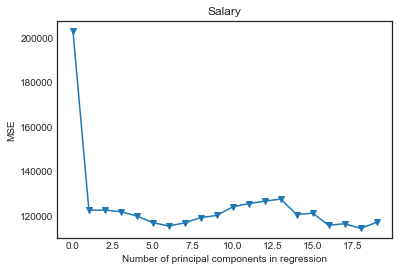

In [0]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [0]:
regr_test = LinearRegression()
regr_test.fit(X_reduced, y)
regr_test.coef_

array([ 106.36859204,  -21.60350456,   24.2942534 ,  -36.9858579 ,
        -58.41402748,   62.20632652,   24.63862038,   15.82817701,
         29.57680773,   99.64801199,  -30.11209105,   20.99269291,
         72.40210574, -276.68551696,  -74.17098665,  422.72580227,
       -347.05662353, -561.59691587,  -83.25441536])

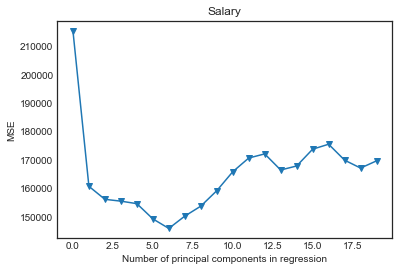

In [0]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [0]:
X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

96320.020782503212

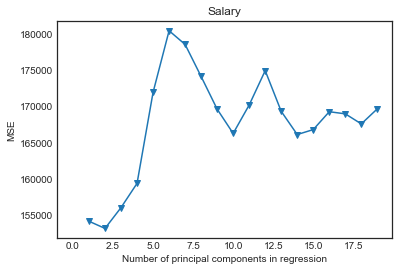

In [0]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits=10, shuffle=False, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

In [0]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

102234.27995999219